In [1]:
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
import seaborn as sns

import sys
sys.path.append('../')
import paradime.routines
import paradime.utils

In [2]:
mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)

In [3]:
num_pts = 5000
mnist_data = mnist.data.reshape(-1, 28*28) / 255.

In [4]:
# paradime.utils.seed_all(42)
foo = paradime.routines.ParametricTSNE(
    perplexity=50,
    dataset=mnist_data[:num_pts],
    init_epochs=5,
    epochs=50,
    batch_size=500,
    use_cuda=True,
    verbose=True
)

2022-08-07 16:04:52,236: Registering dataset.


In [5]:
foo.train()

2022-08-07 16:05:02,891: Adding entry 'pca' to dataset.
2022-08-07 16:05:02,892: Computing global relations 'rel'.
2022-08-07 16:05:02,892: Indexing nearest neighbors.
2022-08-07 16:05:15,567: Calculating probabilities.
2022-08-07 16:05:16,236: Beginning training phase 'pca_init'.
2022-08-07 16:05:18,322: Loss after epoch 0: 199.81938484311104
2022-08-07 16:05:18,901: Beginning training phase 'embedding'.
2022-08-07 16:05:19,234: Loss after epoch 0: 7.053427875041962
2022-08-07 16:05:20,717: Loss after epoch 5: 6.635281026363373
2022-08-07 16:05:22,240: Loss after epoch 10: 6.390940546989441
2022-08-07 16:05:23,690: Loss after epoch 15: 6.388688683509827
2022-08-07 16:05:25,190: Loss after epoch 20: 6.355080485343933
2022-08-07 16:05:26,703: Loss after epoch 25: 6.124158024787903
2022-08-07 16:05:28,148: Loss after epoch 30: 6.095379889011383
2022-08-07 16:05:29,664: Loss after epoch 35: 6.162970662117004
2022-08-07 16:05:31,177: Loss after epoch 40: 6.039008259773254
2022-08-07 16:05:

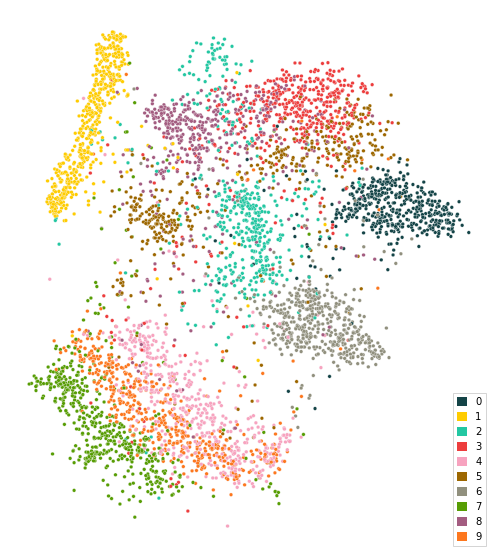

In [6]:
paradime.utils.scatterplot(foo.apply(mnist_data[:num_pts]), mnist.targets[:num_pts]);

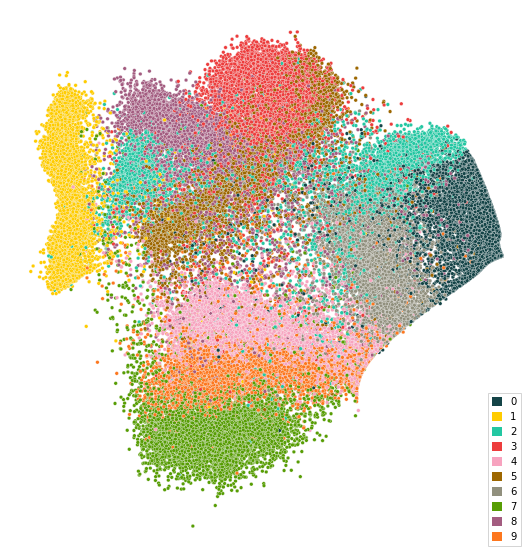

In [22]:
paradime.utils.scatterplot(
    foo.apply(mnist.data.reshape(-1, 28*28) / 255.),
    mnist.targets
);

In [18]:
dr = prdm.routines.ParametricUMAP(
    n_neighbors=100,
    dataset=testdata,
    verbose=True,
    use_cuda=True,
)
dr.train()

2022-08-03 14:48:32.9: Registering dataset.
2022-08-03 14:48:32.9: Computing global relations 'rel'.
2022-08-03 14:48:32.9: Indexing nearest neighbors.
2022-08-03 14:48:36.1: Calculating probabilities.
2022-08-03 14:48:40.1: Adding entry 'spectral' to dataset.
2022-08-03 14:48:40.1: Beginning training phase 'spectral_init'.
2022-08-03 14:48:43.3: Loss after epoch 0: 234.6755457520485
2022-08-03 14:48:44.0: Beginning training phase 'embedding'.
2022-08-03 14:48:44.8: Loss after epoch 0: 25870.835957050323
2022-08-03 14:48:48.8: Loss after epoch 5: 1614.1222553253174
2022-08-03 14:48:52.7: Loss after epoch 10: 1540.0713629722595
2022-08-03 14:48:56.6: Loss after epoch 15: 1492.4837484359741
2022-08-03 14:49:00.7: Loss after epoch 20: 1381.2301726341248
2022-08-03 14:49:04.7: Loss after epoch 25: 1326.8734226226807


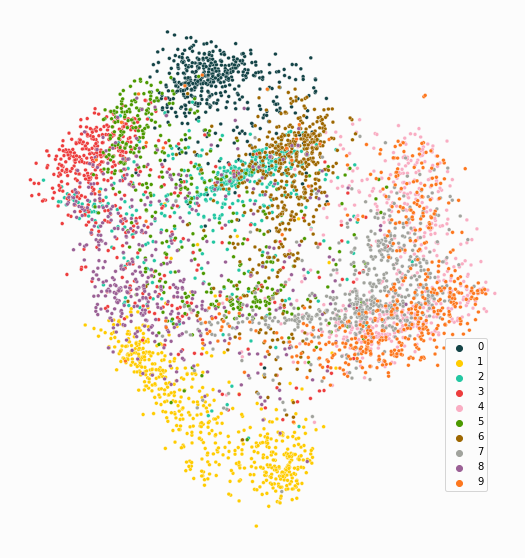

In [19]:
emb = dr(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [112]:
class EmbeddingClassificationHybrid(prdm.models.Model):

    def __init__(self,
        in_dim: int,
        class_dim: int,
        emb_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.class_dim = class_dim
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.class_layer = torch.nn.Linear(cur_dim, class_dim)
        self.emb_layer = torch.nn.Linear(cur_dim, emb_dim)

    def common_forward(self, x):
        for layer in self.layers:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        x = torch.nn.Softmax(dim=1)(x)
        return x

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def forward(self, x):
        return self.embed(x)    

In [118]:
mymodel = EmbeddingClassificationHybrid(28*28, 10, 2, [50, 50])

foo = prdm.ParametricDR(
    model=mymodel,
    dataset={
        'data': testdata,
        'labels': testtargets,
    },
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=[
            prdm.transforms.PerplexityBasedRescale(
                perplexity=50
            ),
            prdm.transforms.Symmetrize()
        ]
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=1.),
            prdm.transforms.Normalize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
foo.add_training_phase(prdm.TrainingPhase(
    name='main',
    n_epochs=30,
    batch_size=500,
    loss=prdm.loss.CompoundLoss([
        prdm.loss.RelationLoss(
            loss_function=prdm.loss.kullback_leibler_div
        ),
        prdm.loss.ClassificationLoss()
        ],
        weights=[1., 190.],
    )
))
foo.train()

2022-08-03 16:04:23.1: Registering dataset.
2022-08-03 16:04:23.1: Computing global relations 'rel'.
2022-08-03 16:04:23.1: Indexing nearest neighbors.
2022-08-03 16:04:27.7: Calculating probabilities.
2022-08-03 16:04:28.1: Beginning training phase 'main'.
2022-08-03 16:04:28.6: Loss after epoch 0: 7834.165466308594
2022-08-03 16:04:31.3: Loss after epoch 5: 6434.125244140625
2022-08-03 16:04:33.8: Loss after epoch 10: 6100.394226074219
2022-08-03 16:04:36.5: Loss after epoch 15: 6201.397705078125
2022-08-03 16:04:39.2: Loss after epoch 20: 6040.8719482421875
2022-08-03 16:04:41.8: Loss after epoch 25: 5873.6700439453125


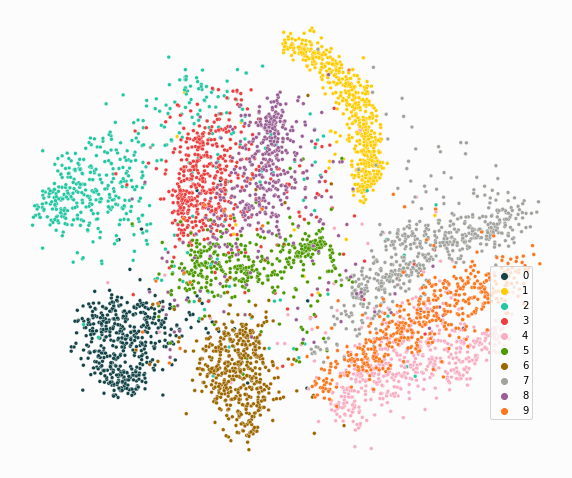

In [119]:
emb = foo.embed(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [120]:
(foo.model.classify(testdata.cuda()).detach().cpu().argmax(dim=1).numpy() == testtargets).sum()

4418

In [122]:
a,b = [ lo.history for lo in foo.training_phases[0].loss.losses ]

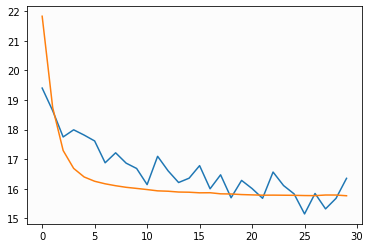

In [126]:
plt.plot(np.array(a)/190.)
plt.plot(b)

In [47]:
prdm.utils.seed_all(42)

dr = prdm.routines.ParametricTSNE(
    perplexity=100,
    dataset=testdata,
)
dr.train()

In [33]:
import seaborn as sns

In [44]:
def plot_result(data, labels):
    palette = sns.color_palette(prdm.utils.get_color_palette().values())
    fig = plt.figure(figsize=(10,10))
    sp = sns.scatterplot(
        x=data[:,0],
        y=data[:,1],
        hue=labels,
        s=14.,
        alpha=1.,
        edgecolor="white",
        palette=palette
    )
    sp.tick_params(bottom=False, left=False)
    sp.set(xticklabels=[],yticklabels=[], aspect=1.)
    sns.despine(top=True, left=True, bottom=True, right=True)
    sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

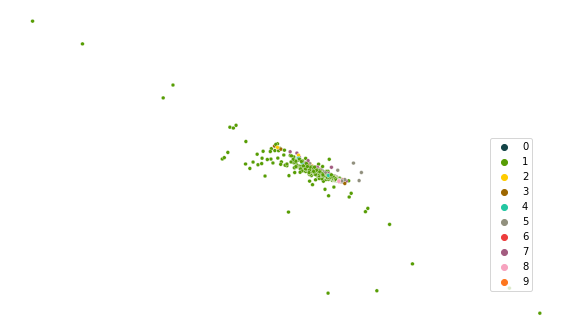

In [48]:
plot_result(dr(mnist.data.reshape(-1, 28*28) / 255.).detach(), mnist.targets)

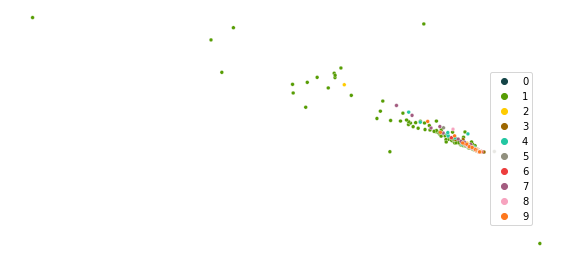

In [49]:
plot_result(dr(testdata).detach(), testtargets)

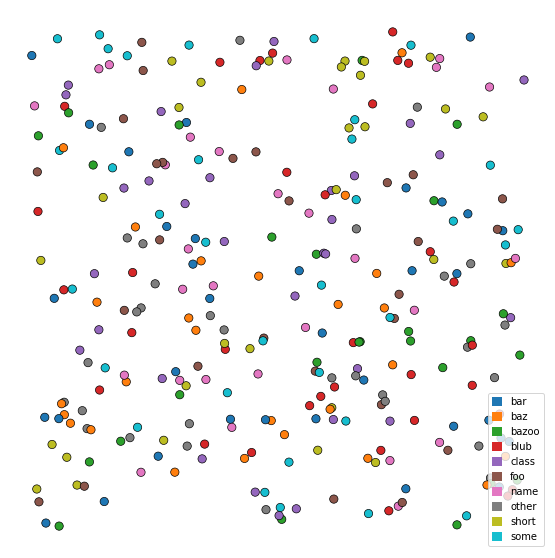

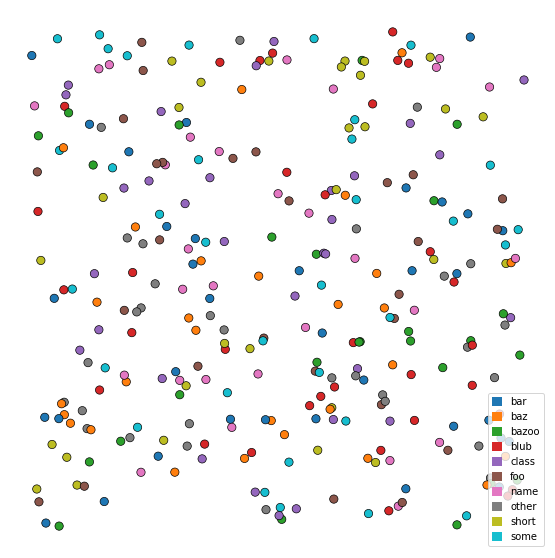

In [146]:
scatterplot(np.random.random((300,2)),labels=np.random.choice(dummy_classes,300),
colormap=list(matplotlib.colors.TABLEAU_COLORS.values()),edgecolor='black')